In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import os
from google.colab import files
from scipy.fftpack import dct
import scipy 
import cvxpy as cvx
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from scipy.signal import medfilt2d
from sklearn.model_selection import ShuffleSplit

In [ ]:
def imgRead(fileName):
    """
    load the input image into a matrix
    :param fileName: name of the input file
    :return: a matrix of the input image
    Examples: imgIn = imgRead('lena.bmp')
    """
    imgIn = plt.imread(fileName)
    return imgIn


def imgShow(imgOut):
    """
    show the image saved in a matrix
    :param imgOut: a matrix containing the image to show
    :return: None
    """
    imgOut = np.uint8(imgOut)
    plt.imshow(imgOut, cmap="gray")

### Load Files

In [ ]:
uploads = files.upload()
images = []
print(uploads.keys())
images.append(imgRead("fishing_boat.bmp"))
lena = imgRead("lena.bmp")
lena = lena[:, :, 0]
images.append(lena)

Saving fishing_boat.bmp to fishing_boat.bmp
Saving lena.bmp to lena.bmp
dict_keys(['fishing_boat.bmp', 'lena.bmp'])


In [ ]:
def imgRecover(img_in, block_size, num_sample):
    """
    Recover the input image from a small size samples
    :param img_in: input image
    :param block_size: block size
    :param num_sample: how many samples in each block
    :return: recovered image
    """
    blocks_img = getBlocks(img_in, block_size)
    sampled_blocks = []
    recovered_blocks = []
    t_matrix = get_td_matrix(block_size)

    for block in blocks_img:
      rasterized_block = block.flatten()
      sampled_indices, estimates = get_estimates_ridge(rasterized_block, num_sample, t_matrix)

      estimates[sampled_indices] = rasterized_block[sampled_indices]
      recon_block = estimates.reshape(block.shape[0], block.shape[1])
      recovered_blocks.append(recon_block)

      sampled_block = np.copy(rasterized_block)
      sampled_block[[i for i in range(len(rasterized_block)) if i not in sampled_indices]] = 0
      sampled_blocks.append(sampled_block.reshape(block.shape[0], block.shape[1]))

    sampled_image = reconstructFromBlocks(sampled_blocks, img_in, block_size)
    recovered_image = reconstructFromBlocks(recovered_blocks, img_in, block_size)
    recovered_image_filtered = medfilt2d(recovered_image)
    imgShow(img_in)
    plt.title("Original Image")
    plt.figure()
    imgShow(sampled_image)
    plt.title("Sampled Image w/ sample number " + str(num_sample))
    plt.figure()
    imgShow(recovered_image)
    plt.title("Unfiltered Recovered Image w/ sample number " + str(num_sample))
    plt.figure()
    imgShow(recovered_image_filtered)
    plt.title("Filtered Recovered Image w/ sample number " + str(num_sample))

    mse_unfiltered = (np.square(img_in - recovered_image)).mean(axis=None)
    mse_filtered = (np.square(img_in - recovered_image_filtered)).mean(axis=None)
    
    print("MSE unfiltered: " + str(mse_unfiltered))
    print("MSE filtered: " + str(mse_filtered))

    return mse_unfiltered, mse_filtered

def get_estimates(block, num_sample, t_matrix):
  sample_indices = np.random.choice(len(block), num_sample, replace=False)
  sampled_b = block[sample_indices]
  sampled_A = t_matrix[sample_indices, :]

  m = round(np.floor(num_sample/6))
  alpha_candidates = np.logspace(-6, 6, 36)
  lasso = Lasso(tol=0.01)
  split = ShuffleSplit(n_splits=20, test_size=m)
  clf = GridSearchCV(estimator=Lasso(), param_grid={"alpha":alpha_candidates}, scoring='neg_mean_squared_error', n_jobs=-1, cv=split, refit=False)
  clf.fit(sampled_A, sampled_b)
  lasso = Lasso(alpha=clf.best_params_['alpha'], tol=0.01)
  lasso.fit(sampled_A, sampled_b)
  estimates = lasso.predict(t_matrix)

  return sample_indices, estimates

def get_estimates_ridge(block, num_sample, t_matrix):
  sample_indices = np.random.choice(len(block), num_sample, replace=False)
  sampled_b = block[sample_indices]
  sampled_A = t_matrix[sample_indices, :]

  m = round(np.floor(num_sample/6))
  alpha_candidates = np.logspace(-3, 3, 10)
  split = ShuffleSplit(n_splits=20, test_size=m)
  clf = GridSearchCV(estimator=Ridge(), param_grid={"alpha":alpha_candidates}, scoring='neg_mean_squared_error', n_jobs=-1, cv=split, refit=False)
  clf.fit(sampled_A, sampled_b)
  ridge = Ridge(alpha=clf.best_params_['alpha'], tol=0.01)
  ridge.fit(sampled_A, sampled_b)
  estimates = ridge.predict(t_matrix)

  return sample_indices, estimates


def get_estimates_single(block, num_sample, t_matrix):
  sample_indices = np.random.choice(len(block), num_sample, replace=False)
  sampled_b = block[sample_indices]
  sampled_A = t_matrix[sample_indices, :]

  lasso = Lasso(alpha=0.01, tol=0.01)
  lasso.fit(sampled_A, sampled_b)
  estimates = lasso.predict(t_matrix)

  return sample_indices, estimates

def get_td_matrix(block_size):
    p, q = block_size, block_size
    t_d_list = []
    for u in range(p):
        for v in range(q):
            t_d = np.empty((q, p))
            for x in range(q):
                for y in range(p):
                    x_m = x + 1
                    y_m = y + 1
                    u_m = u + 1
                    v_m = v + 1
                    if u_m == 1:
                        alpha = np.sqrt(1/p)
                    else:
                        alpha = np.sqrt(2/p)
                    if v_m == 1:
                        beta = np.sqrt(1/q)
                    else:
                        beta = np.sqrt(2/q)
                    first = np.cos(np.pi * (2 * x_m - 1) * (u_m - 1) / (2 * p))
                    second = np.cos(np.pi * (2 * y_m - 1) * (v_m - 1) / (2 * q))
                    t_d[y, x] = alpha * beta * first * second
            t_d = t_d.flatten().reshape(-1, 1)
            t_d_list.append(t_d)
    t_d_matrix = np.hstack(t_d_list)
    return t_d_matrix

# Split image into kxk blocks
def getBlocks(img_in, block_size):
    blocks = []
    for x in range(int(img_in.shape[0] / block_size)):
        for y in range(int(img_in.shape[1] / block_size)):
            block = img_in[x*block_size:x*block_size+block_size, y*block_size:y*block_size+block_size]
            float_block = block.astype(float)
            blocks.append(float_block)
    return blocks

def reconstructFromBlocks(blocks, img_in, block_size):
  recon_image = np.zeros(img_in.shape)
  count = 0
  for x in range(int(img_in.shape[0] / block_size)):
      for y in range(int(img_in.shape[1] / block_size)):
          recon_image[x*block_size:x*block_size+block_size, y*block_size:y*block_size+block_size] = blocks[count]
          count += 1
  return recon_image

def plotSampled(img_in, block_size, num_sample):
  blocks_img = getBlocks(img_in, block_size)
  sampled_blocks = []
  recovered_blocks = []
  chosen_alphas = []
  mean_scores = []
  alpha_total = []
  t_matrix = get_td_matrix(block_size)
  for block in blocks_img:
    rasterized_block = block.flatten()
    sample_indices = np.random.choice(len(rasterized_block), num_sample, replace=False)
    sample_block = np.copy(rasterized_block)
    sample_block[[i for i in range(len(rasterized_block)) if i not in sample_indices]] = 0
    sampled_blocks.append(sample_block.reshape(block.shape[0], block.shape[1]))
  sampled_image = reconstructFromBlocks(sampled_blocks, img_in, block_size)
  plt.figure()
  imgShow(sampled_image)
  plt.title("Sampled Image w/ sample number " + str(num_sample))

def dct2(a):
    return scipy.fftpack.dct( scipy.fftpack.dct( a, axis=0, norm='ortho' ), axis=1, norm='ortho' )

def idct2(a):
    return scipy.fftpack.idct( scipy.fftpack.idct( a, axis=0 , norm='ortho'), axis=1 , norm='ortho')

MSE unfiltered: 988.9506567708333
MSE filtered: 1078.5690947916664
MSE unfiltered: 760.2473619791664
MSE filtered: 890.997081835937
MSE unfiltered: 577.5282145254628
MSE filtered: 691.0198622106475
MSE unfiltered: 416.1327279947915
MSE filtered: 475.02772322591096
MSE unfiltered: 230.27674674999983
MSE filtered: 264.38985173958315


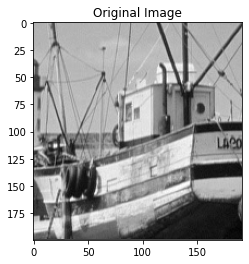

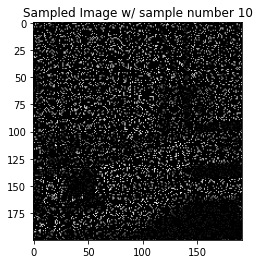

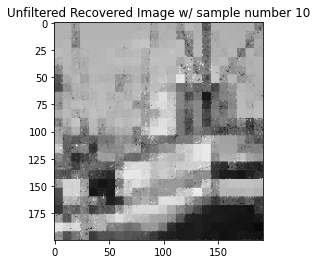

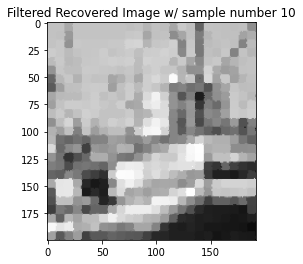

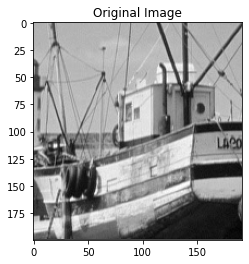

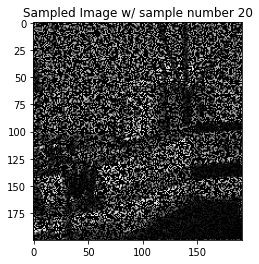

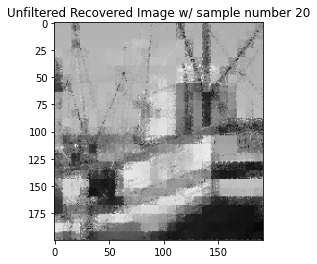

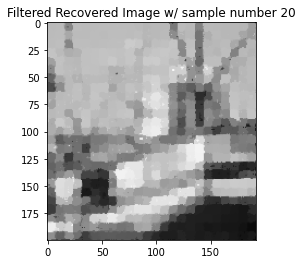

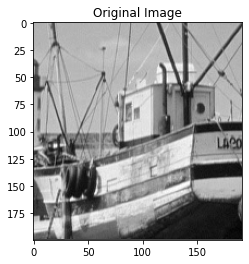

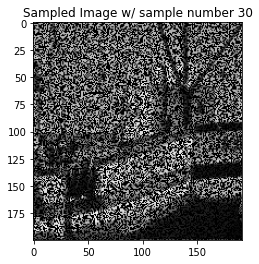

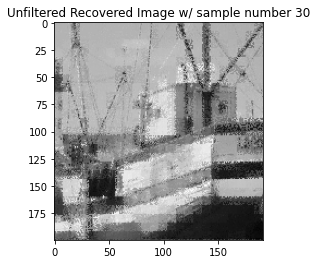

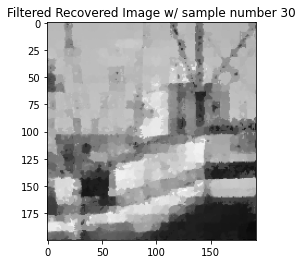

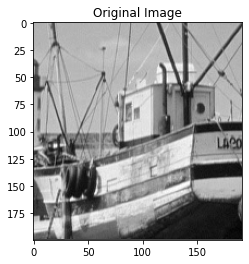

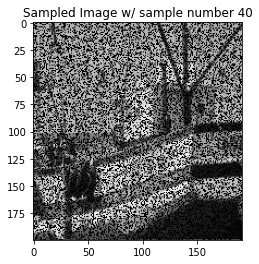

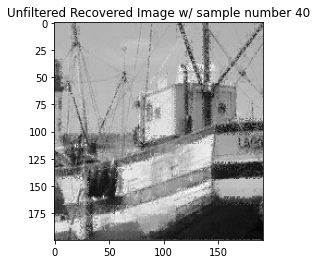

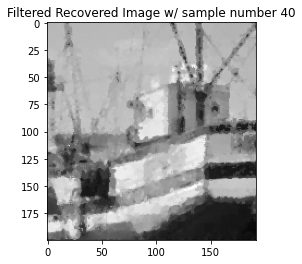

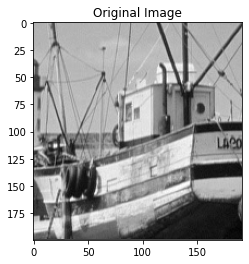

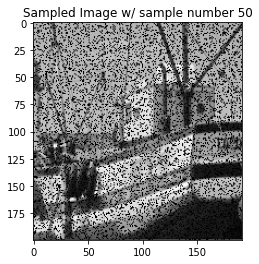

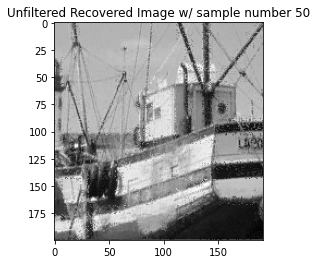

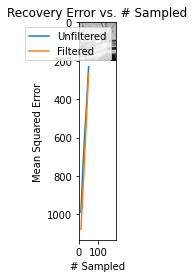

In [ ]:
# Get recovered images for boat
mse_unfiltered_boat = np.zeros(5)
mse_filtered_boat = np.zeros(5)

mse_unfiltered_boat[0], mse_filtered_boat[0] = imgRecover(images[0], 8, 10)
plt.figure()
mse_unfiltered_boat[1], mse_filtered_boat[1] = imgRecover(images[0], 8, 20)
plt.figure()
mse_unfiltered_boat[2], mse_filtered_boat[2] = imgRecover(images[0], 8, 30)
plt.figure()
mse_unfiltered_boat[3], mse_filtered_boat[3] = imgRecover(images[0], 8, 40)
plt.figure()
mse_unfiltered_boat[4], mse_filtered_boat[4] = imgRecover(images[0], 8, 50)

# Plot recovery error for boat
index = [10, 20, 30, 40, 50]
plt.plot(index, mse_unfiltered_boat, label='Unfiltered')
plt.plot(index, mse_filtered_boat, label="Filtered")
plt.title("Recovery Error vs. # Sampled")
plt.xlabel("# Sampled")
plt.ylabel("Mean Squared Error")
plt.legend()

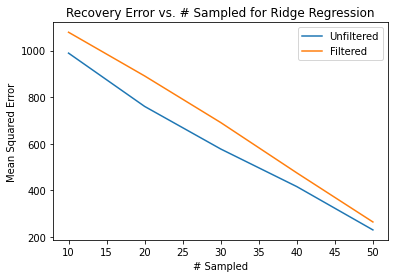

In [ ]:
index = [10, 20, 30, 40, 50]
plt.plot(index, mse_unfiltered_boat, label='Unfiltered')
plt.plot(index, mse_filtered_boat, label="Filtered")
plt.title("Recovery Error vs. # Sampled for Ridge Regression")
plt.xlabel("# Sampled")
plt.ylabel("Mean Squared Error")
plt.legend()

In [ ]:
# Get recovered images for lena
mse_unfiltered_lena = np.zeros(5)
mse_filtered_lena = np.zeros(5)

mse_unfiltered_lena[0], mse_filtered_lena[0] = imgRecover(images[1], 16, 10)
plt.figure()
mse_unfiltered_lena[1], mse_filtered_lena[1] = imgRecover(images[1], 16, 30)
plt.figure()
mse_unfiltered_lena[2], mse_filtered_lena[2] = imgRecover(images[1], 16, 50)
plt.figure()
mse_unfiltered_lena[3], mse_filtered_lena[3] = imgRecover(images[1], 16, 100)
plt.figure()
mse_unfiltered_lena[4], mse_filtered_lena[4] = imgRecover(images[1], 16, 150)

# Plot recovery error for boat
index = [10, 30, 50, 100, 150]
plt.plot(index, mse_unfiltered_lena, label='Unfiltered')
plt.plot(index, mse_filtered_lena, label="Filtered")
plt.title("Recovery Error vs. # Sampled")
plt.xlabel("# Sampled")
plt.ylabel("Mean Squared Error")
plt.legend()

MSE unfiltered: 285.6707748357906
MSE filtered: 256.592394824851


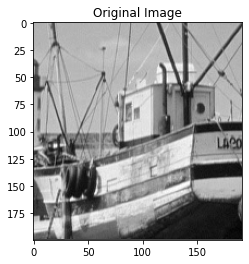

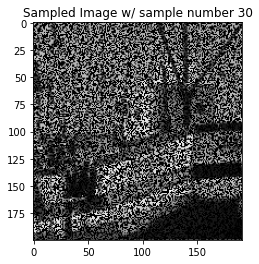

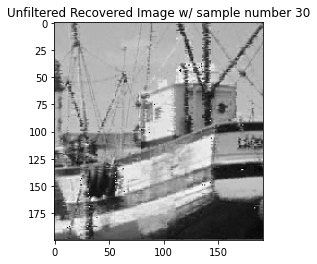

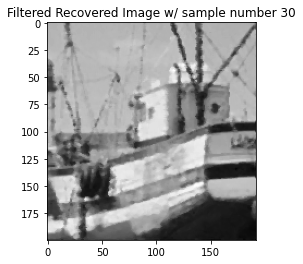

In [ ]:
mse_unfiltered_boat_16, mse_filtered_boat_16= imgRecover(images[0], 8, 30)